In [1]:
# Zdefiniowanie struktury
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

In [2]:
# Przeciążenie podstawowych operatorów
import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)
# Przeciążenie podstawowych funkcji
import Base: abs, sin, cos, tan, exp, sqrt, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

In [3]:
# Promocja typów i konwersja
import Base: convert, promote_rule

In [4]:
#convert(::Type{Dual}, x::T) where T<:Real = Dual(x, zero(x))
#promote_rule(::Type{Dual}, ::Type{T}) where T<:Real = Dual

In [5]:
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
@show Dual{Float64}[Dual(1,2), Dual(3,0)];

Dual{Float64}[Dual(1, 2), Dual(3, 0)] = Dual{Float64}[Dual{Float64}(1.0, 2.0), Dual{Float64}(3.0, 0.0)]


In [6]:
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
@show Dual{Float64}[1, 2, 3];

Dual{Float64}[1, 2, 3] = Dual{Float64}[Dual{Float64}(1.0, 0.0), Dual{Float64}(2.0, 0.0), Dual{Float64}(3.0, 0.0)]


In [7]:
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}
@show Dual(1,2) * 3;

Dual(1, 2) * 3 = Dual{Int64}(3, 6)


In [8]:
# Pomocne funkcje
import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

In [9]:
ReLU(x) = max(zero(x), x)
σ(x) = one(x) / (one(x) + exp(-x))
tanh(x) = 2.0 / (one(x) + exp(-2.0x)) - one(x)
f(x) = x > zero(x) ? x : zero(x)
ϵ = Dual(0., 1.)

x = -1.0:0.05:+1.0
y = partials.(f.(x .+ ϵ));

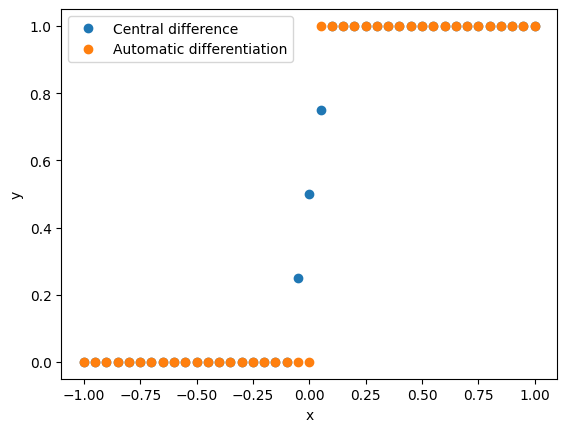

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XaELc/src/init.jl:198
┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/bach/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject Text(24.000000000000007, 0.5, 'y')

In [10]:
center_diff(f, x₀; Δx=1e-3) = ( f(x₀ + Δx) - f(x₀ - Δx) )/2Δx
ŷ = center_diff.(ReLU, x; Δx=1e-1)
using PyPlot
plot(x, ŷ, "o")
plot(x, y, "o")
legend(("Central difference", "Automatic differentiation"))
xlabel("x")
ylabel("y")

In [11]:
D = derivative(f, x) = partials(f(Dual(x, one(x))))

derivative (generic function with 1 method)

In [12]:
J = function jacobian(f, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    
    for i=1:length(args)
        x = Dual{T}[]
        for j=1:length(args)
            seed = (i == j)
            push!(x, seed ?
                Dual(args[j], one(args[j])) :
                Dual(args[j],zero(args[j])) )
        end
        column = partials.([f(x)...])
        push!(jacobian_columns, column[:,:])
    end
    hcat(jacobian_columns...)
end

jacobian (generic function with 1 method)

In [13]:
#J = function jacobian(f, args::Vector)
#    jacobian_columns = Matrix[]
#    #println("jacobian of ", f, " => ", typeof(jacobian_columns))
#    
#    for i=1:length(args)
#        x = Dual[]
#        for j=1:length(args)
#            seed = (i == j)
#            push!(x, seed ?
#                Dual(args[j], one(args[j])) :
#                Dual(args[j],zero(args[j])) )
#        end
#        column = partials.([f(x)...])
#        push!(jacobian_columns, column[:,:])
#    end
#    hcat(jacobian_columns...)
#end

In [14]:
H = function hessian(f, args::Vector)
    ∇f(x::Vector) = J(f, x)
    J(∇f, args)
end

hessian (generic function with 1 method)

In [15]:
n = 5.2
@show [n...];
v = [3.1,3.3]
@show [v...];
@show typeof(v);
@show typeof(v[:,:]);

[n...] = [5.2]
[v...] = [3.1, 3.3]
typeof(v) = Vector{Float64}
typeof(v[:, :]) = Matrix{Float64}


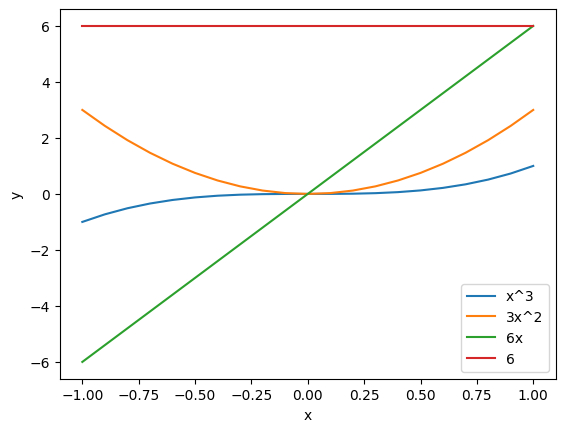

PyObject <matplotlib.legend.Legend object at 0x13bb71730>

In [16]:
f(x) = x^3
f′(x) = derivative(f,  x)
f″(x) = derivative(f′, x)
f‴(x) = derivative(f″, x)
x = -1:0.1:+1

using PyPlot
plot(x,  f.(x))
plot(x, f′.(x))
plot(x, f″.(x))
plot(x, f‴.(x))
xlabel("x")
ylabel("y")
legend(("x^3", "3x^2", "6x", "6"))

Działa dla funkcji jednej zmiennych, a czy na wielu zmiennych?

In [17]:
f(x::Vector) = sum(sin, x) + prod(tan, x) * sum(sqrt, x);
H(f, [0.986403, 0.140913, 0.294963, 0.837125, 0.650451])

5×5 Matrix{Float64}:
 0.585108  3.48082  1.7706    0.994056  1.03257
 3.48082   1.06079  5.79298   3.25244   3.3787
 1.7706    5.79298  0.423982  1.65416   1.71818
 0.994056  3.25244  1.65416   0.251395  0.964565
 1.03257   3.3787   1.71818   0.964565  0.140688

In [18]:
f(x::Vector) = x[1]^3 + x[1]*x[2]
H(f, [1., 2.])

2×2 Matrix{Float64}:
 6.0  1.0
 1.0  0.0

In [19]:
f(x::Vector) = sum(x.^2)
H(f, [1, 2, 3])

3×3 Matrix{Int64}:
 2  0  0
 0  2  0
 0  0  2

Teraz sprawdzimy, czy działa liczenie jakobianu funkcji wektorowej:

In [20]:
f(x::Vector) = [2x[1]*x[2], 3x[2]*x[3]]
J(f, [1, 2., 3, 4, 5])

2×5 Matrix{Float64}:
 4.0  2.0  0.0  0.0  0.0
 0.0  9.0  6.0  0.0  0.0

Należy uważać na pomieszanie się $\epsilon$:

In [21]:
D(x -> x*D(y ->       x  + y, 1), 1) # == 1

2

Powyższy wynik jest niepoprawny, bo `x` z zewnętrznego domknięcia jest typu `Dual`:

In [22]:
D(x -> x*D(y -> value(x) + y, 1), 1) # == 1

1

Drugi przykład kodu, który nie robi tego, co byśmy chcieli:

In [23]:
D(x -> x*D(y -> x*y, 1), 4) # == 8

5

In [24]:
f(x::Vector) = x[1]*x[2]
j(x::Vector) = x[1]*J(f, x)
h(x::Vector) = J(j, x)
h([4., 1.])[2,1]

8.0

Dzięki temu możemy liczyć różniczki bardziej zaawansowanych funkcji, np. funkcję aktywacji SoftMax:

In [25]:
import LinearAlgebra: diagm
diagonal(m) = diagm(0 => vec(m))

softmax(x)  =  exp.(x) ./ sum(exp.(x));
dsoftmax(x) = (softmax(x) |> diagonal) .- softmax(x) * (softmax(x) |> transpose);

In [26]:
J(softmax, [0.1, 0.3, 0.99])

3×3 Matrix{Float64}:
  0.168634   -0.0563292  -0.112304
 -0.0563292   0.193498   -0.137169
 -0.112304   -0.137169    0.249473

In [27]:
dsoftmax([0.1, 0.3, 0.99])

3×3 Matrix{Float64}:
  0.168634   -0.0563292  -0.112304
 -0.0563292   0.193498   -0.137169
 -0.112304   -0.137169    0.249473

No i jesteśmy w stanie nauczyć prostą sieć neuronową!

In [28]:
#import LinearAlgebra: diagm
#diagonal(v::Matrix{Float64}) = diagm(0 => vec(v))
#diagonal([1,2,3,4])

In [29]:
#import LinearAlgebra: I
#eye(n::Integer) = Matrix(1.0I, n, n)
#eye(3)

In [30]:
#function ∇W(x, x̂, ŷ, y, Wo)
#    Eŷ  = ŷ - y
#    ŷȳ  = ŷ  |> length |> eye
#    ȳWo = x̂  |> transpose
#    x̄Wh = x  |> transpose
#    ȳx̂  = Wo |> transpose
#    x̂x̄  = x̂  .* (1.0 .- x̂) |> diagonal
#    Eȳ  = ŷȳ * Eŷ
#    Ex̂  = ȳx̂ * Eȳ
#    Ex̄  = x̂x̄ * Ex̂
#    EWo = Eȳ * ȳWo
#    EWh = Ex̄ * x̄Wh
#    return EWo, EWh
#end

In [31]:
mean_squared_loss(y::Vector, ŷ::Vector) = sum(0.5(y - ŷ).^2)
fullyconnected(w::Vector, n::Number, m::Number, v::Vector, activation::Function) = activation.(reshape(w, n, m) * v)
Wh  = randn(10,2)
Wo  = randn(1,10)
dWh = similar(Wh)
dWo = similar(Wo)
x = [1.98;4.434]
y = [0.064]
E = Float64[]

function net(x, wh, wo, y)
    x̂ = fullyconnected(wh, 10, 2, x, σ)
    ŷ = fullyconnected(wo, 1, 10, x̂, u->u)
    
#    EWo, EWh = ∇W(x, x̂, ŷ, y, Wo)
#    dWo .= EWo
#    dWh .= EWh
    
    E = mean_squared_loss(y, ŷ)
end
Ei = net(x, Wh[:], Wo[:], y)

1.8480709576412806

Poniższe komórki można powtarzać wywołując kolejne epoki (chociaż uczymy tylko na jednych danych):

In [32]:
dnet_Wh(x, wh, wo, y) = J(w -> net(x, w, wo, y), wh);
dWh[:] = dnet_Wh(x, Wh[:], Wo[:], y);

dnet_Wo(x, wh, wo, y) = J(w -> net(x, wh, w, y), wo);
dWo[:] = dnet_Wo(x, Wh[:], Wo[:], y);

Poniżej zaimplementowana metoda najszybszego spadku: 
gradienty `dWh` i `dWo` wskazują gradienty, czyli kierunki
najszybszego **wzrostu** wartości funkcji błędu

In [33]:
push!(E, Ei)
Wh -= 0.1dWh
Wo -= 0.1dWo
Ei  = net(x, Wh[:], Wo[:], y)

0.5138884654705994

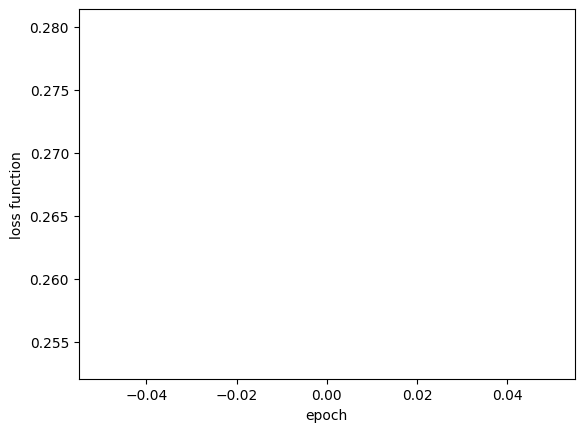

PyObject Text(24.0, 0.5, 'loss function')

In [34]:
plot(log10.(E))#, label="Loss function", marker=:circle)
xlabel("epoch")
ylabel("loss function")

In [40]:
rosenbrock(x, y) = (1.0 - x*x) + 100.0*(y - x*x)*(y - x*x)
v  = -1:.1:+1
n  = length(v)
xv = repeat(v, 1, n)
yv = repeat(v',n, 1)
dz = rosenbrock.(xv .+ ϵ, yv)
dzdx = partials.(dz)
dz = rosenbrock.(xv, yv .+ ϵ)
dzdy = partials.(dz)
z = value.(dz)

21×21 Matrix{Float64}:
 400.0   361.0   324.0   289.0   …  16.0    9.0    4.0    1.0     0.0
 327.8   292.6   259.4   228.2       4.6    1.4    0.2    1.0     3.8
 269.32  237.52  207.72  179.92      0.52   0.72   2.92   7.12   13.32
 222.52  193.72  166.92  142.12      1.72   4.92  10.12  17.32   26.52
 185.6   159.4   135.2   113.0       6.4   12.2   20.0   29.8    41.6
 157.0   133.0   111.0    91.0   …  13.0   21.0   31.0   43.0    57.0
 135.4   113.2    93.0    74.8      20.2   30.0   41.8   55.6    71.4
 119.72   98.92   80.12   63.32     26.92  38.12  51.32  66.52   83.72
 109.12   89.32   71.52   55.72     32.32  44.52  58.72  74.92   93.12
 103.0    83.8    66.6    51.4      35.8   48.6   63.4   80.2    99.0
 101.0    82.0    65.0    50.0   …  37.0   50.0   65.0   82.0   101.0
 103.0    83.8    66.6    51.4      35.8   48.6   63.4   80.2    99.0
 109.12   89.32   71.52   55.72     32.32  44.52  58.72  74.92   93.12
 119.72   98.92   80.12   63.32     26.92  38.12  51.32  66.52

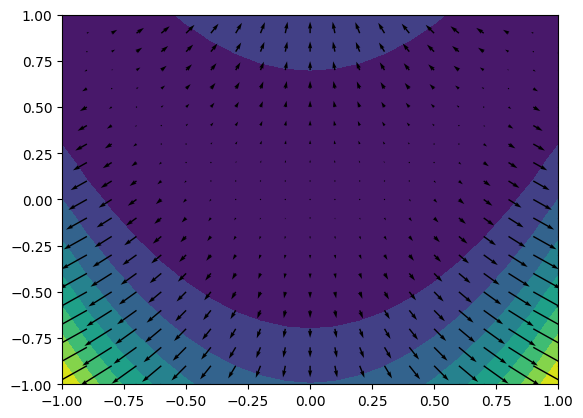

PyObject <matplotlib.quiver.Quiver object at 0x13be0d370>

In [41]:
using PyPlot
contourf(xv, yv, z)
quiver(xv, yv, dzdx, dzdy)